In [1]:
!pip install torch==1.11.0 
!pip install git+https://github.com/gretelai/gretel-synthetics.git

     |██████████████▌                 | 339.2 MB 173.4 MB/s eta 0:00:03

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 750.6 MB 164.9 MB/s            
You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.
  Cloning https://github.com/gretelai/gretel-synthetics.git to /tmp/pip-req-build-6g5nsasa
  Running command git clone --filter=blob:none -q https://github.com/gretelai/gretel-synthetics.git /tmp/pip-req-build-6g5nsasa
  Resolved https://github.com/gretelai/gretel-synthetics.git to commit 2ed9d31ce8f56afd1519c38859ab081e8cdef579
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 67 kB 32.5 MB/s            
     |████████████████████████████████| 1.2 MB 123.5 MB/s            
     |████████████████████████████████| 58 kB 114.1 MB/s            
     |████████████████████████████████| 251 kB 128.5 MB/s            
     |████████████████████████████████| 6.3 MB 118.3 MB/s            
     |████████████████████████████████| 438 kB 120.9 MB/s            
     |███████████████████████████

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from pickle import dump, load
from skimage.util.shape import view_as_windows

import torch

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType

In [3]:
slice0 = pd.read_csv('../data/kagglePump/full_slice0.csv') 
slice1 = pd.read_csv('../data/kagglePump/full_slice1.csv') 
slice2 = pd.read_csv('../data/kagglePump/full_slice2.csv')
slice3 = pd.read_csv('../data/kagglePump/full_slice3.csv') 
slice4 = pd.read_csv('../data/kagglePump/full_slice4.csv')
slice5 = pd.read_csv('../data/kagglePump/full_slice5.csv') 
slice6 = pd.read_csv('../data/kagglePump/full_slice6.csv') 

print(slice0.shape, slice1.shape, slice2.shape, slice3.shape, slice4.shape, slice5.shape, slice6.shape)

(2161, 55) (2161, 55) (2161, 55) (2161, 55) (2161, 55) (2161, 55) (2161, 55)


In [4]:
slices_list = [slice0, slice1, slice2, slice3, slice4, slice5, slice6]

slices_list.pop(4)

print(len(slices_list))

6


In [5]:
COLS_TO_DROP = ['Unnamed: 0','sensor_00', 'sensor_15', 
                'sensor_50', 'sensor_51']
cleanup_nums = {"machine_status": {"NORMAL": 0,
                                   "BROKEN": 1,
                                   "RECOVERING":2}}

for sl in slices_list:
    sl['timestamp']= pd.to_datetime(sl['timestamp']) # cast to datatype
    sl = sl.drop(COLS_TO_DROP,axis=1, inplace=True) # drop cols

for sl in slices_list:
    sl = sl.replace(cleanup_nums)

for sl in slices_list:
    sl = sl.dropna(axis=0, inplace=True) # drop nans

In [6]:
# set up DGAN config.
config = DGANConfig(
    max_sequence_len=720,
    sample_len=20, # trying a larger sample_len
    batch_size=300,
    apply_feature_scaling=True, 
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=10000)

model = DGAN(config)

In [7]:
# loading model 4 and 5
model4 = model.load("../models/dgan_model_4_48_sensors.pt",  map_location=torch.device('cpu'))
model5 = model.load("../models/dgan_model_5_48_sensors.pt",  map_location=torch.device('cpu'))

In [8]:
# Generate synthetic data - this ran near instantly
_, synthetic_features4 = model4.generate_numpy(1000)
_, synthetic_features5 = model5.generate_numpy(1000)

In [9]:
# 1000 samples of 720 cols x 49 rows
synthetic_features4.shape 
synthetic_features5.shape

(1000, 720, 49)

In [10]:
sensor_cols = slice0.columns
sensor_cols = sensor_cols[1:]

In [11]:
synthetic_df_4 = pd.DataFrame(synthetic_features4.reshape(-1, synthetic_features4.shape[2]), columns=sensor_cols)
synthetic_df_5 = pd.DataFrame(synthetic_features5.reshape(-1, synthetic_features5.shape[2]), columns=sensor_cols)

In [18]:
# Concatenating list of dfs into one large one
slices_list
real_slices=pd.concat(slices_list) 
real_slices.drop(['timestamp'], axis=1, inplace=True)
real_slices.head()

,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,...,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,machine_status
0,50.95486,51.258678,44.140625,640.3936,83.42505,13.43316,16.42795,15.33565,15.05353,41.28502,...,40.10416,39.06250,43.48958,41.08796,43.40278,41.956020,41.087960,182.5810,72.04861,0.0
1,50.95486,51.258680,44.140630,645.6019,82.65776,13.38252,16.42795,15.49479,15.05353,40.72804,...,40.10416,39.32291,44.01041,41.66667,43.40278,41.666670,40.798610,186.3426,71.46991,0.0
2,51.04166,51.302080,44.227430,627.8936,83.92866,13.34635,16.42795,15.37182,15.16204,41.02427,...,39.58333,39.32291,44.01041,41.95602,43.11343,41.087960,40.798611,187.2106,71.46991,0.0
3,50.95486,51.258680,44.227428,639.6991,82.42686,13.41146,16.42795,15.37182,15.05353,40.62917,...,39.32291,39.06250,44.27083,41.95602,43.11343,41.087963,40.798611,184.8958,71.18056,0.0
4,50.86805,51.258680,44.227428,641.6666,84.44931,13.43316,16.42795,15.61777,15.08247,41.24120,...,39.06250,39.06250,44.79166,41.95602,42.53472,41.087963,40.798610,179.9769,71.18056,0.0


Comparing the accuracy synthetic data 4 and synthetic data 5 to real data:
I. Correlations
II. Distributions
III. PCA

I. Correlations 
a) Correlation matrices for real, synthetic 4, and synthetic 5 data
b) Correlation matrices for the differences between real and synthetic data
c) Correlations between real and synthetic

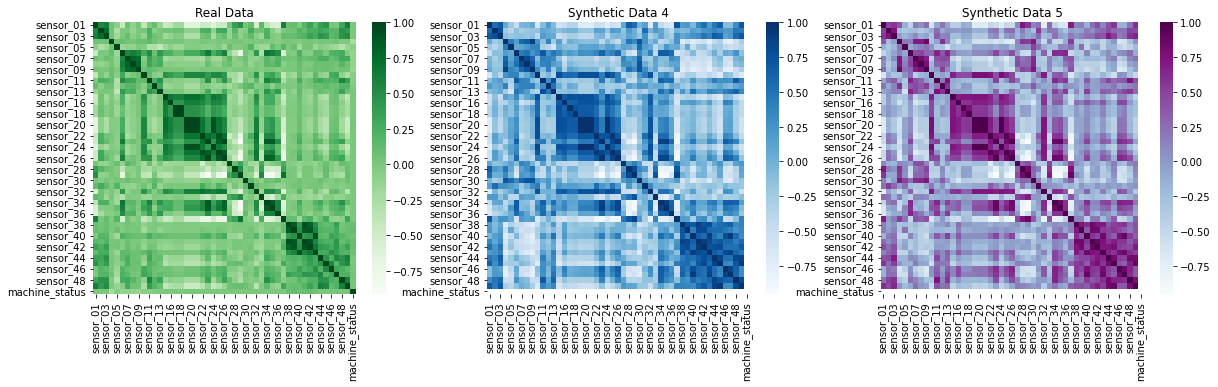

In [19]:
# Correlation matrices: real,synthetic 4,synthetic 5
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
sns.heatmap(real_slices.corr(),cmap='Greens',ax=ax1)
sns.heatmap(synthetic_df_4.corr(),cmap='Blues',ax=ax2)
sns.heatmap(synthetic_df_5.corr(), cmap="BuPu",ax=ax3)

ax1.set_title('Real Data')
ax2.set_title('Synthetic Data 4')
ax3.set_title('Synthetic Data 5')
plt.show()

<AxesSubplot:>

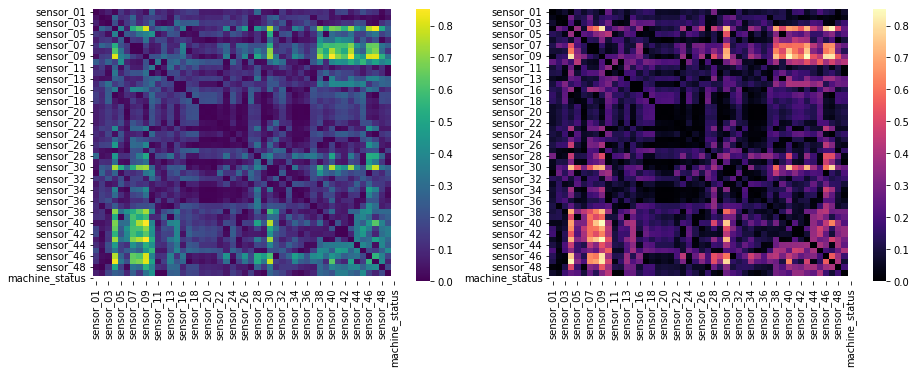

In [59]:
# Let check for differences in correlation
real_synthetic4_corr = (real_slices.corr()-synthetic_df_4.corr()).abs()
real_synthetic5_corr = (real_slices.corr()-synthetic_df_4.corr()).abs()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(real_synthetic4_corr,cmap='viridis',ax=ax1)
sns.heatmap(real_synthetic5_corr,cmap='magma',ax=ax2)

In [24]:
# Autocorrelations
real_slices.corrwith(synthetic_df_4)

sensor_01        -0.066254
sensor_02        -0.002999
sensor_03        -0.066201
sensor_04         0.045009
sensor_05        -0.057820
sensor_06         0.008726
sensor_07        -0.008661
sensor_08         0.015459
sensor_09         0.023413
sensor_10         0.040029
sensor_11         0.003901
sensor_12        -0.025645
sensor_13        -0.020842
sensor_14        -0.055014
sensor_16        -0.002316
sensor_17         0.083070
sensor_18         0.031094
sensor_19         0.069650
sensor_20         0.048322
sensor_21         0.053107
sensor_22         0.000682
sensor_23        -0.010510
sensor_24         0.037709
sensor_25         0.007753
sensor_26         0.059270
sensor_27         0.018550
sensor_28         0.061528
sensor_29         0.039390
sensor_30        -0.046403
sensor_31         0.084676
sensor_32        -0.015402
sensor_33        -0.067551
sensor_34         0.112937
sensor_35         0.079806
sensor_36        -0.186041
sensor_37        -0.046871
sensor_38         0.026214
s

In [26]:
real_slices.corrwith(synthetic_df_5)

sensor_01         0.054518
sensor_02         0.058347
sensor_03         0.052935
sensor_04        -0.108692
sensor_05        -0.024906
sensor_06        -0.021167
sensor_07        -0.011785
sensor_08         0.005639
sensor_09        -0.002626
sensor_10        -0.022035
sensor_11         0.027604
sensor_12         0.119225
sensor_13         0.062047
sensor_14        -0.126827
sensor_16        -0.101375
sensor_17        -0.113447
sensor_18        -0.126628
sensor_19        -0.216322
sensor_20        -0.218223
sensor_21        -0.214526
sensor_22        -0.000433
sensor_23         0.006642
sensor_24        -0.140774
sensor_25        -0.041321
sensor_26        -0.061108
sensor_27        -0.009290
sensor_28         0.011478
sensor_29        -0.038281
sensor_30        -0.001339
sensor_31        -0.039523
sensor_32         0.025216
sensor_33        -0.108026
sensor_34        -0.115333
sensor_35        -0.076705
sensor_36         0.213446
sensor_37         0.018270
sensor_38        -0.023540
s

II. Distributions between of real and synthetic data
a) Sensor 34
b) Sensor 25 
c) Sensor 11
d) Sensor 36

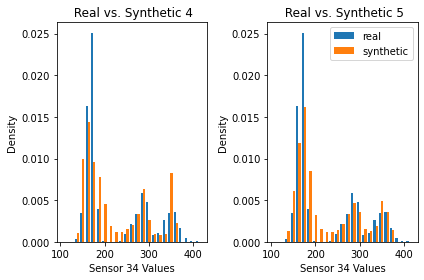

In [27]:
# Compare distributions of sensor_34 values
plt.subplot(1,2,1)                
plt.hist([real_slices['sensor_34'], synthetic_df_4['sensor_34']], 
         label=["real", "synthetic"],
         bins=25,
         density=True)
plt.xlabel("Sensor 34 Values")
plt.ylabel("Density")
plt.title(" Real vs. Synthetic 4")

plt.subplot(1,2,2)               
plt.hist([real_slices['sensor_34'], synthetic_df_5['sensor_34']], 
         label=["real", "synthetic"],
         bins=25,
         density=True)
plt.xlabel("Sensor 34 Values")
plt.ylabel("Density")
plt.title(" Real vs. Synthetic 5")
plt.legend()

plt.tight_layout()                
plt.show()     

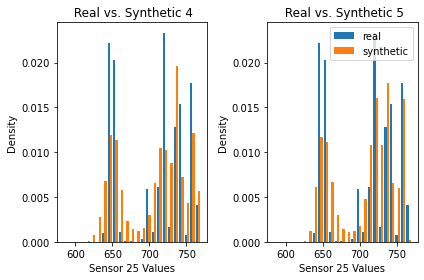

In [29]:
# Compare distributions of sensor_25 values
plt.subplot(1,2,1)                
plt.hist([real_slices['sensor_25'], synthetic_df_4['sensor_25']], 
         label=["real", "synthetic"],
         bins=25,
         density=True)
plt.xlabel("Sensor 25 Values")
plt.ylabel("Density")
plt.title(" Real vs. Synthetic 4")

plt.subplot(1,2,2)               
plt.hist([real_slices['sensor_25'], synthetic_df_5['sensor_25']], 
         label=["real", "synthetic"],
         bins=25,
         density=True)
plt.xlabel("Sensor 25 Values")
plt.ylabel("Density")
plt.title(" Real vs. Synthetic 5")
plt.legend()

plt.tight_layout()                
plt.show()     

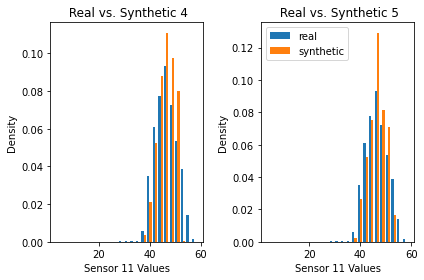

In [30]:
# Compare distributions of sensor_11 values
plt.subplot(1,2,1)                
plt.hist([real_slices['sensor_11'], synthetic_df_4['sensor_11']], 
         label=["real", "synthetic"],
         bins=25,
         density=True)
plt.xlabel("Sensor 11 Values")
plt.ylabel("Density")
plt.title(" Real vs. Synthetic 4")

plt.subplot(1,2,2)               
plt.hist([real_slices['sensor_11'], synthetic_df_5['sensor_11']], 
         label=["real", "synthetic"],
         bins=25,
         density=True)
plt.xlabel("Sensor 11 Values")
plt.ylabel("Density")
plt.title(" Real vs. Synthetic 5")
plt.legend()

plt.tight_layout()                
plt.show()     

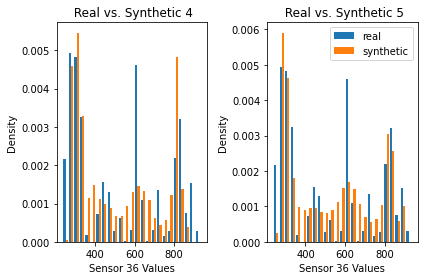

In [31]:
# Compare distributions of sensor_36 values
plt.subplot(1,2,1)                
plt.hist([real_slices['sensor_36'], synthetic_df_4['sensor_36']], 
         label=["real", "synthetic"],
         bins=25,
         density=True)
plt.xlabel("Sensor 36 Values")
plt.ylabel("Density")
plt.title(" Real vs. Synthetic 4")

plt.subplot(1,2,2)               
plt.hist([real_slices['sensor_36'], synthetic_df_5['sensor_36']], 
         label=["real", "synthetic"],
         bins=25,
         density=True)
plt.xlabel("Sensor 36 Values")
plt.ylabel("Density")
plt.title(" Real vs. Synthetic 5")
plt.legend()

plt.tight_layout()                
plt.show()     

III. PCA, based on this [article](https://medium.com/@clever.tech.memes/comparing-similarity-of-two-datasets-using-pca-a-technical-review-of-principal-component-analysis-94e528e4b191)

In [43]:
# PCA 
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
pca = PCA(n_components=2)

real_slices_scaled = scaler.fit(real_slices[:-1]).transform(real_slices[:-1])
synthetic_df_4_scaled = scaler.fit(synthetic_df_4[:-1]).transform(synthetic_df_4[:-1])
synthetic_df_5_scaled = scaler.fit(synthetic_df_5[:-1]).transform(synthetic_df_5[:-1])

In [44]:
real_slices_covar = np.cov(np.transpose(np.array(real_slices_scaled)))
synthetic_df_4_covar = np.cov(np.transpose(np.array(synthetic_df_4_scaled)))
synthetic_df_5_covar = np.cov(np.transpose(np.array(synthetic_df_5_scaled)))
                                                                  
pca_real_slices = pca.fit(real_slices_covar).transform(real_slices_covar)
pca_synthetic_df_4 = pca.fit(synthetic_df_4_covar).transform(synthetic_df_4_covar)
pca_synthetic_df_5 = pca.fit(synthetic_df_5_covar).transform(synthetic_df_5_covar)

In [53]:
def components_to_corr(pca_array1,pca_array2):
    df1,df2 = pd.DataFrame(pca_array1, columns = ['comp1','comp2']), pd.DataFrame(pca_array2, columns = ['comp1','comp2'])
    df_vertically_appended1 = df1['comp1'].append(df1['comp2']).reset_index(drop=True)
    df_vertically_appended2 = df2['comp1'].append(df2['comp2']).reset_index(drop=True)
    return (np.corrcoef(df_vertically_appended1,df_vertically_appended2)[0,1])

In [60]:
print('The correlation between real data and synthetic data 4 is {}'.format(components_to_corr(pca_real_slices, pca_synthetic_df_4)))
print()
print('The correlation between real data and synthetic data 5 is {}'.format(components_to_corr(pca_real_slices, pca_synthetic_df_5)))

The correlation between real data and synthetic data 4 is -0.7204681192054534

The correlation between real data and synthetic data 5 is -0.7294247754986976


Synthetic data 5 seems to be more strongly correlated with the real data compared to synthetic data 4.